Churn Analysis with telco data
##### Irene Bustos


1. Import packages and files
2. Data Cleaning
3. Exploratory Data Analysis
4. ML Model

### 1. Import packages and files

In [1]:
#load packages
import sys
import pandas as pd 
import matplotlib
import numpy as np 
import scipy as sp 
import IPython
from IPython import display
import sklearn #collection of machine learning algorithms
import random
import time
import warnings
warnings.filterwarnings('ignore')
print('-'*25)


# Input data files are available directory.
from subprocess import check_output
print(check_output(["ls", "../yara_telco_churnmodel"]).decode("utf8"))

#Load Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.metrics import accuracy_score,classification_report,recall_score,confusion_matrix,roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
from xgboost import XGBClassifier 
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier
import shap

#Load Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
import matplotlib.ticker as mtick 

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

-------------------------
Customer Churn.xlsx
Data Assignment - Senior Data Analyst Incubation.docx
Q1_churn_model_IreneBustos.ipynb
catboost_info
churn_model.ipynb
logs.log
report.html
test_irene_old.ipynb



In [2]:
#import data from file:
d_raw = pd.read_excel('../yara_telco_churnmodel/Customer Churn.xlsx', header=0)
d_raw = pd.DataFrame(d_raw)
d_raw = d_raw.drop(d_raw.columns[[0, 1, 2, 3, 6, 7, 8]], axis=1)
d_raw.drop_duplicates(inplace=True)

#to play with our data we'll create a copy
d_1 = d_raw.copy(deep = True)

#preview data
print (d_1.info())
print(d_1.describe())
#data_raw.head() 
#data_raw.tail() 
d_1.sample(10) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   City               7043 non-null   object 
 1   Zip Code           7043 non-null   int64  
 2   Gender             7043 non-null   object 
 3   Senior Citizen     7043 non-null   object 
 4   Partner            7043 non-null   object 
 5   Dependents         7043 non-null   object 
 6   Tenure Months      7043 non-null   int64  
 7   Phone Service      7043 non-null   object 
 8   Multiple Lines     7043 non-null   object 
 9   Internet Service   7043 non-null   object 
 10  Online Security    7043 non-null   object 
 11  Online Backup      7043 non-null   object 
 12  Device Protection  7043 non-null   object 
 13  Tech Support       7043 non-null   object 
 14  Streaming TV       7043 non-null   object 
 15  Streaming Movies   7043 non-null   object 
 16  Contract           7043 

,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Reason
619,Buellton,93427,Female,No,No,No,1,Yes,No,Fiber optic,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),85.55,85.55,Yes,Moved
6872,Canoga Park,91304,Female,No,No,No,70,Yes,Yes,Fiber optic,...,No,Yes,Yes,Two year,Yes,Mailed check,111.15,7737.55,No,NaN
1775,Whittier,90605,Female,Yes,No,No,64,Yes,No,DSL,...,Yes,Yes,No,Two year,Yes,Credit card (automatic),70.20,4481,Yes,Lack of affordable download/upload speed
4163,Sacramento,95825,Male,No,No,No,56,Yes,Yes,No,...,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),25.95,1444.05,No,NaN
2000,Pasadena,91101,Male,No,Yes,No,14,Yes,No,DSL,...,Yes,Yes,Yes,Two year,No,Mailed check,81.95,1181.75,No,NaN
3356,San Diego,92124,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.85,8477.7,No,NaN
6531,Hood,95639,Male,No,Yes,Yes,57,Yes,Yes,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,74.30,4018.35,No,NaN
2572,Alameda,94502,Female,No,No,Yes,13,No,No phone service,DSL,...,No,No,No,Month-to-month,No,Electronic check,30.15,382.2,No,NaN
6683,Nubieber,96068,Male,No,Yes,Yes,31,Yes,No,DSL,...,Yes,No,No,Month-to-month,No,Mailed check,54.35,1647,No,NaN
656,San Lucas,93954,Male,Yes,Yes,No,36,Yes,Yes,Fiber optic,...,No,No,Yes,Month-to-month,Yes,Credit card (automatic),85.25,3132.75,Yes,Product dissatisfaction


### 2. Data Cleaning

### 2.1 first data cleaning

In [3]:
# 1) check null values. First I will convert Total Charges into float 
d_1['Total Charges']=pd.to_numeric(d_1['Total Charges'], errors='coerce', downcast='float')
    
print('Null values in training dataset:\n', d_1.isnull().sum())
print("-"*10)

 # 2) Rows with Total Charges null check
    #null_columns=d_1.columns[d_1.isnull().any()]
    #print(d_1[d_1["Total Charges"].isnull()])
# as we can see all rows with Total Charges = null they have tenrure months = 0 we can replace Total Charges with Monthly charges
d_1['Total Charges'].fillna(d_1['Monthly Charges'], inplace = True)

null_columns=d_1.columns[d_1.isnull().any()]
print('Null values in Total charges:\n')
print(d_1[d_1['Total Charges'].isnull()])
# total charges replacement check
# print(d_1.loc[d_1['CustomerID'] == '4472-LVYGI'])

# 3) convert object into category and also Tenure Months into float
# Create a list with desired datatypes for each column we want to change
data_types_dic = {'City':'category','Gender':'category','Senior Citizen':'category','Partner':'category',
                  'Dependents':'category', 'Tenure Months': 'float','Phone Service':'category', 'Multiple Lines':'category',
                  'Internet Service':'category','Online Security':'category','Online Backup':'category','Device Protection':'category',
                 'Tech Support':'category','Streaming TV':'category','Streaming Movies':'category','Contract':'category',
                  'Paperless Billing':'category','Payment Method':'category','Total Charges':'float64',
                  'Churn Label':'category',
                  'Churn Reason':'category'}

d_1 = d_1.astype(data_types_dic)
print(d_1.dtypes)


Null values in training dataset:
 City                    0
Zip Code                0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Reason         5174
dtype: int64
----------
Null values in Total charges:

Empty DataFrame
Columns: [City, Zip Code, Gender, Senior Citizen, Partner, Dependents, Tenure Months, Phone Service, Multiple Lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Paperless Billing, Payment Method, Monthly Charges, Tot

In [4]:
# create churn column with 1-0 instead of "No"&"Yes"
d_1['Churn'] = d_1['Churn Label'].str.replace("Yes", "1").str.replace("No", "0").astype(int)
    
# check results
print(d_1[['Churn', 'Churn Label']].sample(10))

# create target column
Target=['Churn']

# create dataset without target 
d_1_x = d_1.drop(columns=['Churn', 'Churn Label', 'Churn Reason'])
print(d_1_x)


      Churn Churn Label
6462      0          No
1331      1         Yes
4567      0          No
2665      0          No
161       1         Yes
4560      0          No
5215      0          No
2384      0          No
906       1         Yes
6883      0          No
              City  Zip Code  Gender Senior Citizen Partner Dependents  \
0      Los Angeles     90003    Male             No      No         No   
1      Los Angeles     90005  Female             No      No        Yes   
2      Los Angeles     90006  Female             No      No        Yes   
3      Los Angeles     90010  Female             No     Yes        Yes   
4      Los Angeles     90015    Male             No      No        Yes   
...            ...       ...     ...            ...     ...        ...   
7038       Landers     92285  Female             No      No         No   
7039      Adelanto     92301    Male             No     Yes        Yes   
7040         Amboy     92304  Female             No     Yes        Yes

#### 2.2 Create a report with pandas profile to see more detail about data inside data set

In [5]:
profile = ProfileReport(d_1, title="Pandas Profiling Report Churn")
profile.to_file('report.html')
# NOTE: open report created inside the folder 

From the profiling report we have some insights to have into consideration in the coming steps:
1. City & Zipcode hava high cardinality (64959 cities and only ~7K row in all dataset, > as a quick solution I will remove this columns in the first model. IDEALLY: be ideal to find a database with population in these areas and use the type of city or postcode by # population/density or purchasing power so we can clasify customers depending on the caracteristics of the area where they live.
2. In Tenure Months we see a lot of frequency in the maximum (72 months: 5,1% from total customers) and minimum value (1 month: 8.7% from total customers).
3. Clear concentration of customers in the lower Montlhy charges group.

#### 2.3 Get the share of churn inside each type of category for each column != float

In [6]:
# 1) Check data from all variables to see if we can get more insights 

for x in d_1_x:
    if d_1[x].dtype != 'float64':
        print('_'*50)
        print('***COLUMN:',x,'\n')
        print('Churn Proportion by:', x)
        print(d_1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')


__________________________________________________
***COLUMN: City 

Churn Proportion by: City
              City  Churn
0           Acampo   0.75
1            Acton   0.00
2         Adelanto   0.20
3             Adin   0.50
4     Agoura Hills   0.40
...            ...    ...
1124         Yreka   0.00
1125     Yuba City   0.25
1126       Yucaipa   0.25
1127  Yucca Valley   0.00
1128         Zenia   0.25

[1129 rows x 2 columns]
---------- 

__________________________________________________
***COLUMN: Zip Code 

Churn Proportion by: Zip Code
      Zip Code  Churn
0        90001   0.40
1        90002   0.20
2        90003   0.20
3        90004   0.40
4        90005   0.60
...        ...    ...
1647     96145   0.25
1648     96146   0.00
1649     96148   0.50
1650     96150   1.00
1651     96161   1.00

[1652 rows x 2 columns]
---------- 

__________________________________________________
***COLUMN: Gender 

Churn Proportion by: Gender
   Gender     Churn
0  Female  0.269209
1    Male  

**Insights from the charts above:**
1. Churn probability when customer has no "Internet Service" are only ~7% vs ~18% with DSL and ~41% with Fiber optic:
   * We assume that older people has less probability to have internet so older people have less churn ratio.
   * We assume Fiber optic market is more competitive (more common in the city centers also). IDEALLY: show a map locating customers with Fiber optic.
2. Churn probability with paperless billing is much higher (33% vs 16% in No paperless billing). Older people prefer bills in paper. It suppports the assuption above.
3. Payment methods automatic as "Bank transfer (automatic)" & "Credit card (automatic)" have ~ same churn ratio. We can group both as 'Automatic payment'. 
4. Payment method "Mail check" has less churn ratio than "Electronic check" (~19% mail vs ~45% electronic). Having into consideration that young people are less probable to use a mail method, this supports also that older people have less churn ratio.
2. Gender seem not to be relevant to predict churn.

In [7]:
# Group for automatic payment method.
d_1['Payment Method'] = d_1['Payment Method'].apply(lambda x: 'Automatic payment' if (x == 'Bank transfer (automatic)' or x == 'Credit card (automatic)') else x)

# Create a column 'IsAlone' if the customer has no partner and no dependents.
def alone_logic(x):  
    if x['Partner']== 'No' and x['Dependents'] == 'No' :
        return 1
    else:
        return 0

d_1['IsAlone'] = d_1.apply(lambda x: alone_logic(x), axis=1)

print(d_1)


              City  Zip Code  Gender Senior Citizen Partner Dependents  \
0      Los Angeles     90003    Male             No      No         No   
1      Los Angeles     90005  Female             No      No        Yes   
2      Los Angeles     90006  Female             No      No        Yes   
3      Los Angeles     90010  Female             No     Yes        Yes   
4      Los Angeles     90015    Male             No      No        Yes   
...            ...       ...     ...            ...     ...        ...   
7038       Landers     92285  Female             No      No         No   
7039      Adelanto     92301    Male             No     Yes        Yes   
7040         Amboy     92304  Female             No     Yes        Yes   
7041  Angelus Oaks     92305  Female             No     Yes        Yes   
7042  Apple Valley     92308    Male             No      No         No   

      Tenure Months Phone Service    Multiple Lines Internet Service  ...  \
0               2.0           Yes 

## 3. Perform Exploratory Analysis
Questions to solve:
* Correlation between variables to see if we can remove any of them 
* Correlation churn vs variables
* Total churn ratio and total revenue
* Churn by churn reason
* Revenue oportunity of loosing a customer
* Other graphs to undertand data.


#### 3.1. Create columns with useful information to start the exploratory analysis

In [8]:
# In order to visualize better how the Monthly charges influences churn ratio I will create bins using Montly Charges
# is a way to discretize it into equal-sized buckets based on on sample quantiles
d_1['Monthly Charges Bin']=pd.qcut(d_1['Monthly Charges'].astype(int), 4)

# same for tenure months
d_1['Tenure Months Bin']=pd.qcut(d_1['Tenure Months'].astype(int), 4)

# coding services using 1-0 instead of 'Yes"/'No'
services_coding_dic = {'Yes':'1','No':'0','No phone service':'0','No internet service':'0','Fiber optic':'2','DSL':'1'}

d_1['Phone Service Code'] = d_1['Phone Service'].map(services_coding_dic).astype(int)
d_1['Internet Service Code'] = d_1['Internet Service'].map(services_coding_dic).astype(int)
d_1['Multiple Lines Code'] = d_1['Multiple Lines'].map(services_coding_dic).astype(int)
d_1['Online Security Code'] = d_1['Online Security'].map(services_coding_dic).astype(int)
d_1['Online Backup Code'] = d_1['Online Backup'].map(services_coding_dic).astype(int)
d_1['Device Protection Code'] = d_1['Device Protection'].map(services_coding_dic).astype(int)
d_1['Tech Support Code'] = d_1['Tech Support'].map(services_coding_dic).astype(int)
d_1['Streaming TV Code'] = d_1['Streaming TV'].map(services_coding_dic).astype(int)
d_1['Streaming Movies Code'] = d_1['Streaming Movies'].map(services_coding_dic).astype(int)

print(d_1)

# There are lots of services in the dataset (Phone, Internet, Multiple line, Online backup, .....) and I would like to group 
# them in two groups: "main" vs "extra" (main: phone or internet) / extra: multiple lines, Online Security, Online Backup, Device Protection, Tech Support, Streaming Movies.

d_1['Internet Service Code (Group)'] = d_1['Internet Service'].apply(lambda x: '0' if (x == 'No') else '1').astype(int)
d_1['Main Services #'] = d_1['Phone Service Code'] + d_1['Internet Service Code (Group)']
d_1['Extra Services #'] = d_1['Multiple Lines Code'] + d_1['Online Security Code'] + d_1['Online Backup Code'] + d_1['Device Protection Code'] + d_1['Tech Support Code'] + d_1['Streaming TV Code'] + d_1['Streaming Movies Code']

# Convert categorical variables into dummy variables
colums_dummy = [
'Gender',
'Senior Citizen',
'Partner',
'Dependents',
'Contract',
'Paperless Billing',
'Payment Method',
'Internet Service',
'Main Services #',
'Extra Services #']

# get dummies
d_1_dummies = pd.get_dummies(data=d_1, columns=[col for col in d_1.columns if col in colums_dummy])

print(d_1_dummies.info())

              City  Zip Code  Gender Senior Citizen Partner Dependents  \
0      Los Angeles     90003    Male             No      No         No   
1      Los Angeles     90005  Female             No      No        Yes   
2      Los Angeles     90006  Female             No      No        Yes   
3      Los Angeles     90010  Female             No     Yes        Yes   
4      Los Angeles     90015    Male             No      No        Yes   
...            ...       ...     ...            ...     ...        ...   
7038       Landers     92285  Female             No      No         No   
7039      Adelanto     92301    Male             No     Yes        Yes   
7040         Amboy     92304  Female             No     Yes        Yes   
7041  Angelus Oaks     92305  Female             No     Yes        Yes   
7042  Apple Valley     92308    Male             No      No         No   

      Tenure Months Phone Service    Multiple Lines Internet Service  ...  \
0               2.0           Yes 

#### 3.2. Correlation between variables

None


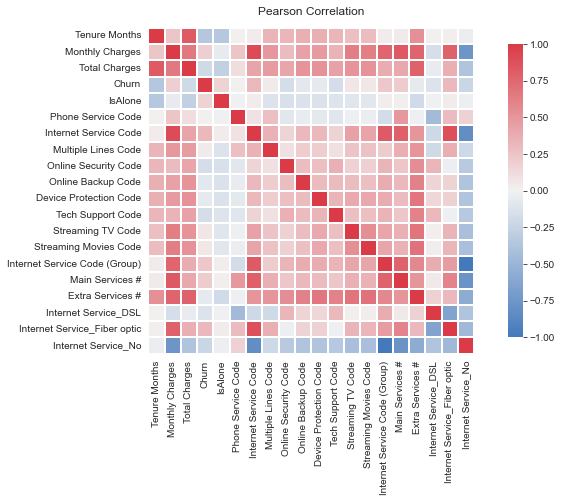

In [9]:
colums_dummy_corr_graph = [
'Internet Service']
          

# get dummies
d_1_colums_dummy_corr_graph = pd.get_dummies(data=d_1, columns=[col for col in d_1.columns if col in colums_dummy_corr_graph])
d_1_colums_dummy_corr_graph_ok = d_1_colums_dummy_corr_graph.drop(columns=[
'City'  , 
'Zip Code' ,
'Tenure Months Bin'])


def correlation_heatmap(colums_dummy_correlation_graph_ok):
    _ , ax = plt.subplots(figsize =(12, 6))
    colormap = sns.diverging_palette(250, 10, as_cmap = True)
    
    _ = sns.heatmap(
        colums_dummy_correlation_graph_ok.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax,
        #annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':0 }
    )
    
    plt.title('Pearson Correlation', y=1.02, size=12)
    
    
    

print(correlation_heatmap(d_1_colums_dummy_corr_graph_ok))

#### 3.3. Correlation churn vs resto of variables

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Variable')

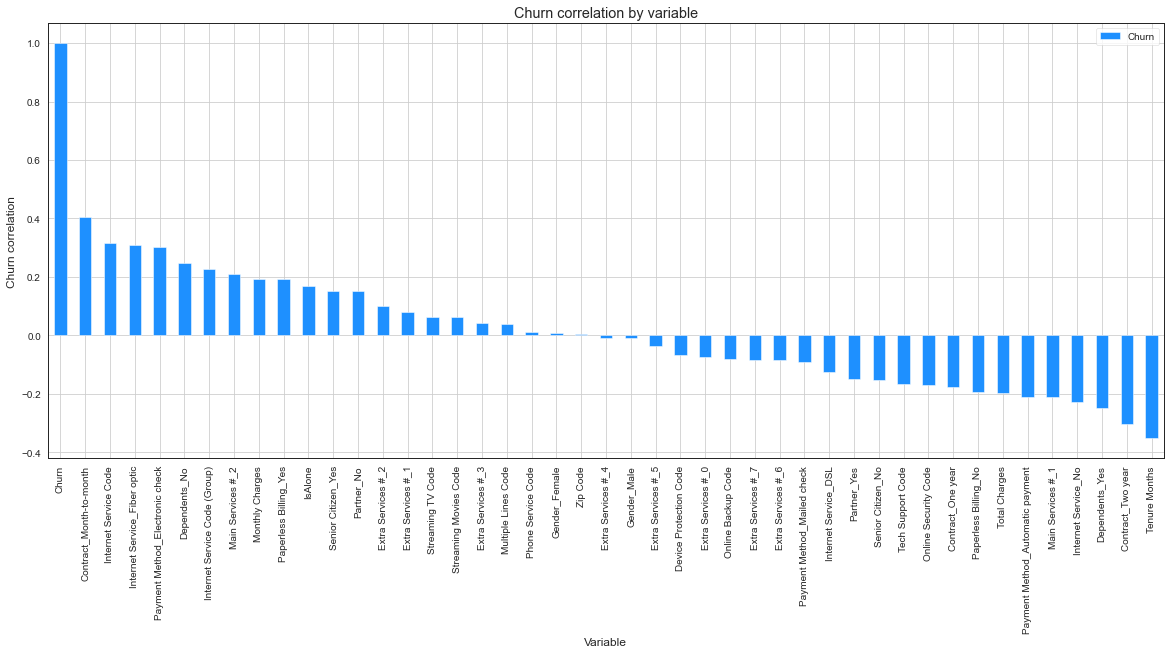

In [10]:
# Correlation of churn
plt.figure(figsize=(20,8))
print(d_1_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar', grid=True, legend=True, color='dodgerblue'))
plt.title('Churn correlation by variable')
plt.ylabel('Churn correlation')
plt.xlabel('Variable')

#### 3.4. Total churn ratio

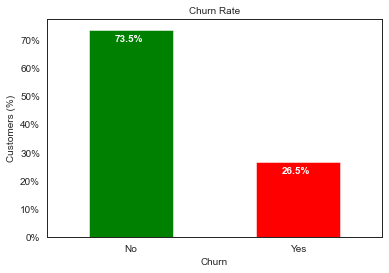

In [11]:
# get total churn ratio
colors = ['green','red']
ax = (d_1['Churn Label'].value_counts()*100.0 /len(d_1)).plot(kind='bar',stacked = True, rot = 0, color = colors,
                                                                         figsize = (6,4))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Customers (%)',size = 10)
ax.set_xlabel('Churn',size = 10)
ax.set_title('Churn Rate', size = 10)

totals = []

for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='white',
           weight = 'bold',
           size = 10)

#### 3.5 what is the oportunity in revenue if we can retain a customer?
We can see the opportunity revenue from retain a churn is USD 976 (total charges of USD 1.680 when the customer is not churn - total charges USD 704 when customer is churn)

In [12]:
print('Median total charges by type of customers (churn vs non churn):')
print(round(d_1.groupby('Churn', as_index=False)['Total Charges'].median(),0))

print('total current revenues ($):', round(d_1['Total Charges'].sum(),0))

Median total charges by type of customers (churn vs non churn):
   Churn  Total Charges
0      0         1680.0
1      1          704.0
total current revenues ($): 16056624.0


#### 3.6 Other graphs and visualizations to analyse our data

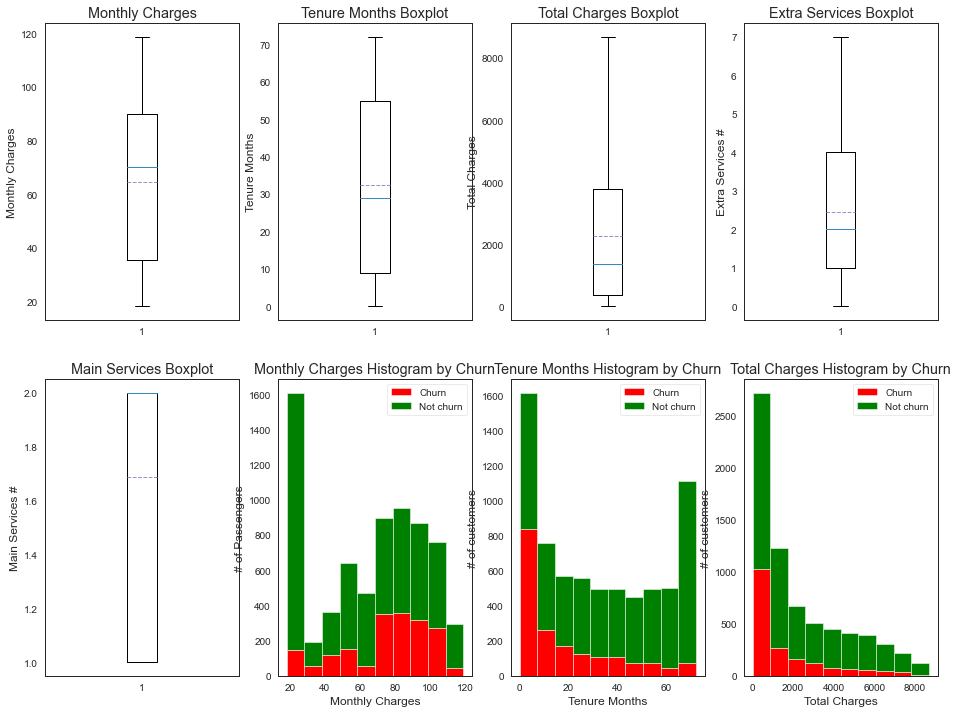

In [13]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(241)
plt.boxplot(x=d_1['Monthly Charges'], showmeans = True, meanline = True)
plt.title('Monthly Charges')
plt.ylabel('Monthly Charges')

plt.subplot(242)
plt.boxplot(d_1['Tenure Months'], showmeans = True, meanline = True)
plt.title('Tenure Months Boxplot')
plt.ylabel('Tenure Months')

plt.subplot(243)
plt.boxplot(d_1['Total Charges'], showmeans = True, meanline = True)
plt.title('Total Charges Boxplot')
plt.ylabel('Total Charges')

plt.subplot(244)
plt.boxplot(d_1['Extra Services #'], showmeans = True, meanline = True)
plt.title('Extra Services Boxplot')
plt.ylabel('Extra Services #')

plt.subplot(245)
plt.boxplot(d_1['Main Services #'], showmeans = True, meanline = True)
plt.title('Main Services Boxplot')
plt.ylabel('Main Services #')


plt.subplot(246)
plt.hist(x = [d_1[d_1['Churn']==1]['Monthly Charges'], d_1[d_1['Churn']==0]['Monthly Charges']], 
         stacked=True, color = ['r','g'],label = ['Churn','Not churn'])
plt.title('Monthly Charges Histogram by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(247)
plt.hist(x = [d_1[d_1['Churn']==1]['Tenure Months'], d_1[d_1['Churn']==0]['Tenure Months']], 
         stacked=True, color = ['r','g'],label = ['Churn','Not churn'])
plt.title('Tenure Months Histogram by Churn')
plt.xlabel('Tenure Months')
plt.ylabel('# of customers')
plt.legend()

plt.subplot(248)
plt.hist(x = [d_1[d_1['Churn']==1]['Total Charges'], d_1[d_1['Churn']==0]['Total Charges']], 
         stacked=True, color = ['r','g'],label = ['Churn','Not churn'])
plt.title('Total Charges Histogram by Churn')
plt.xlabel('Total Charges')
plt.ylabel('# of customers')
plt.legend()

<AxesSubplot:xlabel='Internet Service Code', ylabel='Churn'>

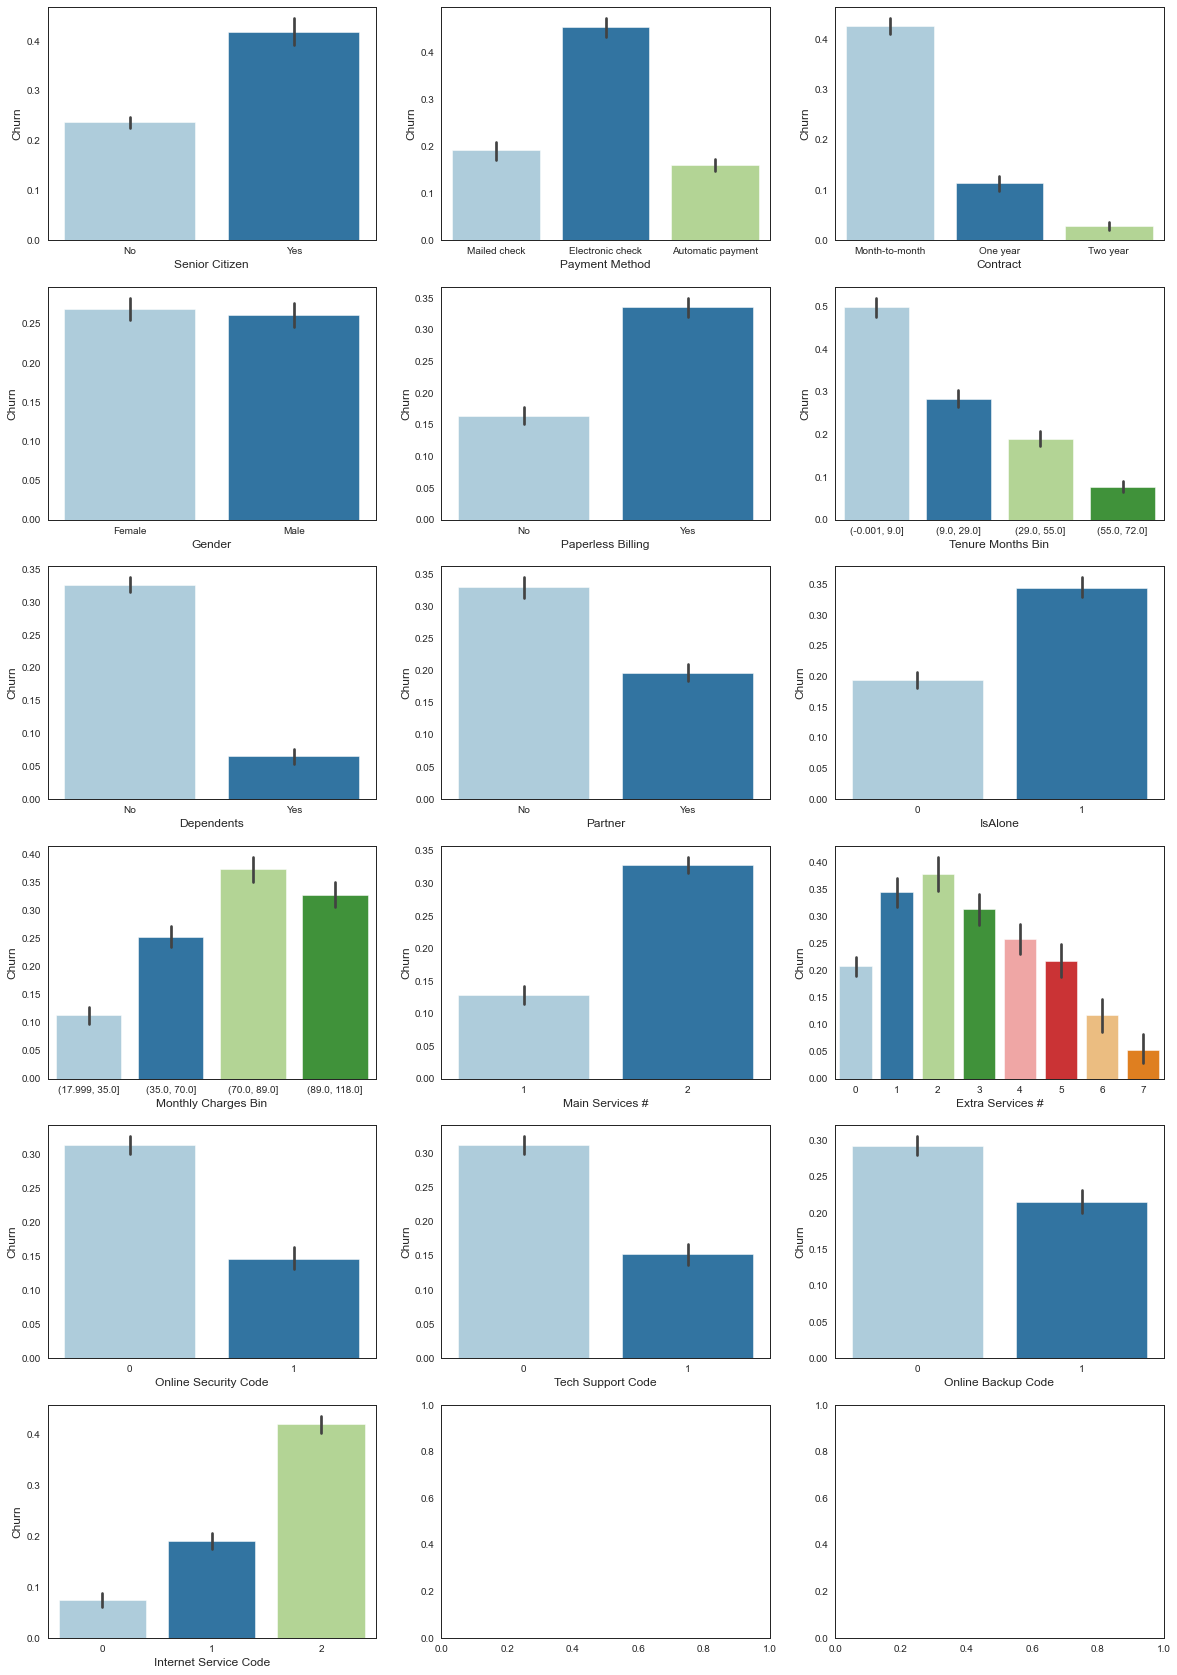

In [14]:

fig, saxis = plt.subplots(6, 3,figsize=(20,30)) 

sns.barplot(x = 'Senior Citizen', y = 'Churn', data=d_1, ax = saxis[0,0],  palette = 'Paired')


sns.barplot(x = 'Payment Method', y = 'Churn', data=d_1, ax = saxis[0,1],  palette = 'Paired')
sns.barplot(x = 'Contract', y = 'Churn', data=d_1, ax = saxis[0,2],  palette = 'Paired')

sns.barplot(x = 'Gender', y = 'Churn', data=d_1, ax = saxis[1,0],  palette = 'Paired')
sns.barplot(x = 'Paperless Billing', y = 'Churn', data=d_1, ax = saxis[1,1],  palette = 'Paired')
sns.barplot(x = 'Tenure Months Bin', y = 'Churn', data=d_1, ax = saxis[1,2],  palette = 'Paired')

sns.barplot(x = 'Dependents', y = 'Churn', data=d_1, ax = saxis[2,0],  palette = 'Paired')
sns.barplot(x = 'Partner', y = 'Churn', data=d_1, ax = saxis[2,1],  palette = 'Paired')
sns.barplot(x = 'IsAlone', y = 'Churn', data=d_1, ax = saxis[2,2],  palette = 'Paired')

sns.barplot(x = 'Monthly Charges Bin', y = 'Churn', data=d_1, ax = saxis[3,0],  palette = 'Paired')
sns.barplot(x = 'Main Services #', y = 'Churn', data=d_1, ax = saxis[3,1],  palette = 'Paired')
sns.barplot(x = 'Extra Services #', y = 'Churn', data=d_1, ax = saxis[3,2],  palette = 'Paired')

sns.barplot(x = 'Online Security Code', y = 'Churn', data=d_1, ax = saxis[4,0],  palette = 'Paired')
sns.barplot(x = 'Tech Support Code', y = 'Churn', data=d_1, ax = saxis[4,1],  palette = 'Paired')
sns.barplot(x = 'Online Backup Code', y = 'Churn', data=d_1, ax = saxis[4,2],  palette = 'Paired')

sns.barplot(x = 'Internet Service Code' , y = 'Churn', data=d_1, ax = saxis[5,0],  palette = 'Paired')


Text(0.5, 1.0, 'Is Alone vs # Services Comparison')

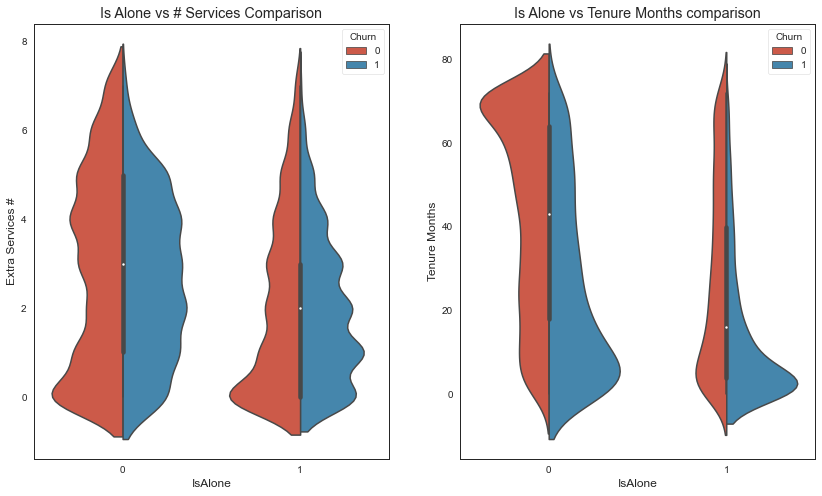

In [15]:

fig,(axis1,axis2) = plt.subplots(1,2,figsize=(14,8))

# sns.violinplot(x = 'Contract', y = 'Tenure Months', hue = 'Churn', data = d_1, split = True, ax = axis1)
# axis1.set_title('Contract vs Tenure Months Comparison')

sns.violinplot(x = 'IsAlone', y = 'Tenure Months', hue = 'Churn',data = d_1, split = True, ax = axis2)
axis2.set_title('Is Alone vs Tenure Months comparison')

sns.violinplot(x = 'IsAlone', y = 'Extra Services #', hue = 'Churn',data = d_1, split = True, ax = axis1)
axis1.set_title('Is Alone vs # Services Comparison')


## 4. ML Model 
1. Dataframe creation for taget and predictor variables to use in the models
2. Using Pycaret to get the first comparison from a wide range of ML models
3. Random Forest Classifier Model
4. Catboost Model
5. LightGBM Model
6. XGBoost Model

##### 4.1 Dataframe creation for taget and predictor variables to use in the model

In [16]:
d_1_ml_model = d_1_dummies[['Tenure Months',
'Monthly Charges',
'Total Charges',
'Churn',
'Gender_Female',
'Gender_Male',
'Senior Citizen_No',
'Senior Citizen_Yes',
'Partner_No',
'Partner_Yes',
'Dependents_No',
'Dependents_Yes',
'Paperless Billing_No',
'Paperless Billing_Yes',
'Internet Service_DSL',
'Internet Service_Fiber optic',
'Internet Service_No',
'Contract_Month-to-month',
'Contract_One year',
'Contract_Two year',
'Payment Method_Automatic payment',
'Payment Method_Electronic check',
'Payment Method_Mailed check',
'IsAlone',
'Phone Service Code',
'Multiple Lines Code',
'Online Security Code',
'Online Backup Code',
'Device Protection Code',
'Tech Support Code',
'Streaming TV Code',
'Streaming Movies Code',
'Main Services #_1',
'Main Services #_2',
'Extra Services #_0',
'Extra Services #_1',
'Extra Services #_2',
'Extra Services #_3',
'Extra Services #_4',
'Extra Services #_5',
'Extra Services #_6',
'Extra Services #_7'
]]

print(d_1_ml_model)
# We will use the data frame where we had created dummy variables
y = d_1_ml_model['Churn'].values
X = d_1_ml_model.drop(columns = ['Churn'])


      Tenure Months  Monthly Charges  Total Charges  Churn  Gender_Female  \
0               2.0            53.85     108.150002      1              0   
1               2.0            70.70     151.649994      1              1   
2               8.0            99.65     820.500000      1              1   
3              28.0           104.80    3046.050049      1              1   
4              49.0           103.70    5036.299805      1              0   
...             ...              ...            ...    ...            ...   
7038           72.0            21.15    1419.400024      0              1   
7039           24.0            84.80    1990.500000      0              0   
7040           72.0           103.20    7362.899902      0              1   
7041           11.0            29.60     346.450012      0              1   
7042           66.0           105.65    6844.500000      0              0   

      Gender_Male  Senior Citizen_No  Senior Citizen_Yes  Partner_No  \
0  

##### 4.2 Using Pycaret to get the first comparison from a wide range of ML models

In [17]:
#init setup
from pycaret.classification import *
s = setup(d_1_ml_model, target='Churn', ignore_features = [])

,Description,Value
0,session_id,6560
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(7043, 42)"
5,Missing Values,False
6,Numeric Features,32
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [18]:
# compare all models
best_model = compare_models(sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8008,0.8577,0.5459,0.6640,0.5982,0.4677,0.4722,0.1350
ada,Ada Boost Classifier,0.8041,0.8556,0.5823,0.6595,0.6176,0.4868,0.4891,0.0440
lr,Logistic Regression,0.8008,0.8537,0.5704,0.6546,0.6092,0.4765,0.4788,0.6790
catboost,CatBoost Classifier,0.7957,0.8521,0.5422,0.6498,0.5903,0.4560,0.4597,0.8090
lda,Linear Discriminant Analysis,0.7976,0.8467,0.5749,0.6440,0.6071,0.4715,0.4731,0.0130
lightgbm,Light Gradient Boosting Machine,0.7874,0.8454,0.5444,0.6269,0.5817,0.4404,0.4430,0.0460
rf,Random Forest Classifier,0.7886,0.8339,0.5101,0.6406,0.5669,0.4298,0.4352,0.1060
xgboost,Extreme Gradient Boosting,0.7761,0.8298,0.5324,0.6013,0.5638,0.4142,0.4161,0.2300
nb,Naive Bayes,0.7398,0.8258,0.7796,0.5153,0.6201,0.4346,0.4566,0.0060
et,Extra Trees Classifier,0.7736,0.8038,0.5019,0.6009,0.5461,0.3972,0.4005,0.0980


In [19]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6560, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [20]:
# tune best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7890,0.8489,0.4179,0.6829,0.5185,0.3933,0.4128
1,0.7951,0.8601,0.4254,0.7037,0.5302,0.4092,0.4305
2,0.8012,0.8491,0.5000,0.6837,0.5776,0.4517,0.4611
3,0.8073,0.8594,0.4478,0.7407,0.5581,0.4443,0.4674
4,0.7931,0.8606,0.4627,0.6739,0.5487,0.4204,0.4329
5,0.8134,0.8791,0.5000,0.7283,0.5929,0.4772,0.4914
6,0.8114,0.8472,0.4552,0.7531,0.5674,0.4560,0.4797
7,0.8012,0.8740,0.4074,0.7534,0.5288,0.4167,0.4484
8,0.7789,0.8348,0.3630,0.6806,0.4734,0.3495,0.3772


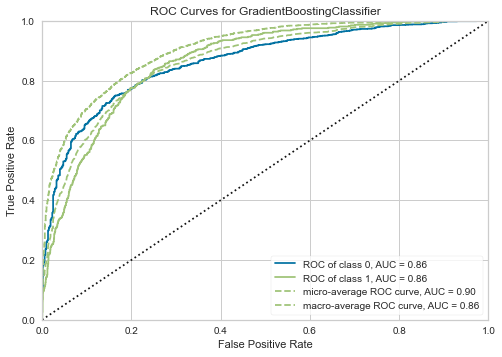

In [21]:
# AUC Plot
plot_model(tuned_best_model, plot = 'auc')

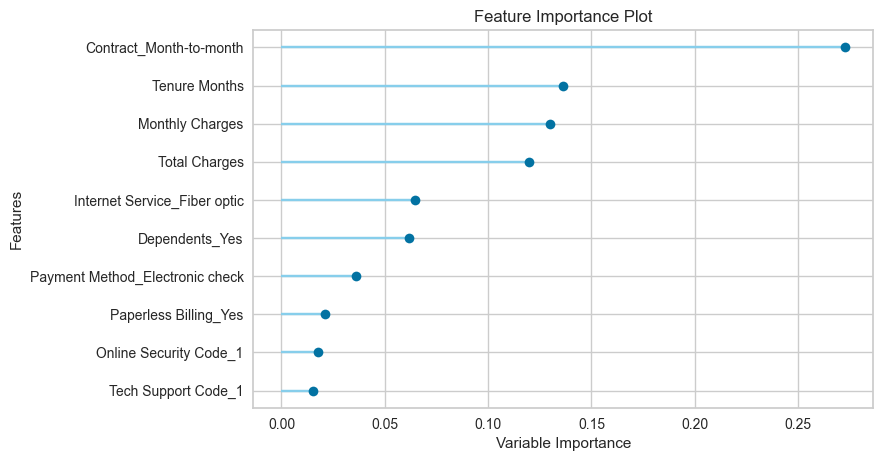

In [22]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

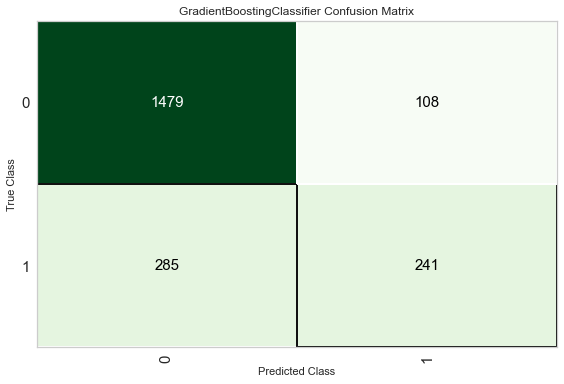

In [23]:
# Confusion Matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')

In a churn model we will try to retain those predicted as churn, true positives and false positives. As an assumption here we will offer USD 100 voucher to all of them. We also know if we retain these churn customers we will increase our revenue by USD 976 in customer lifetime value.

Let's create an additional metric that accounts for "profitability"

In [24]:
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (976-100), 0)
    fp = np.where((y_pred==1) & (y==0), -100, 0)
    return np.sum([tp,fp])
# add metric to PyCaret
add_metric('profit', 'Profit', calculate_profit)
best_model = compare_models(sort='Profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
nb,Naive Bayes,0.7398,0.8258,0.7796,0.5153,0.6201,0.4346,0.4566,81847.2000,0.0090
ada,Ada Boost Classifier,0.8041,0.8556,0.5823,0.6595,0.6176,0.4868,0.4891,64453.2000,0.0500
lda,Linear Discriminant Analysis,0.7976,0.8467,0.5749,0.6440,0.6071,0.4715,0.4731,63357.2000,0.0120
lr,Logistic Regression,0.8008,0.8537,0.5704,0.6546,0.6092,0.4765,0.4788,63051.6000,0.0370
qda,Quadratic Discriminant Analysis,0.5012,0.5620,0.6956,0.3165,0.4308,0.0924,0.1163,61318.4000,0.0100
gbc,Gradient Boosting Classifier,0.8008,0.8577,0.5459,0.6640,0.5982,0.4677,0.4722,60490.8000,0.1600
catboost,CatBoost Classifier,0.7957,0.8521,0.5422,0.6498,0.5903,0.4560,0.4597,59852.8000,0.7060
lightgbm,Light Gradient Boosting Machine,0.7874,0.8454,0.5444,0.6269,0.5817,0.4404,0.4430,59675.6000,0.0270
ridge,Ridge Classifier,0.8006,0.0000,0.5347,0.6678,0.5932,0.4634,0.4688,59316.8000,0.0080
xgboost,Extreme Gradient Boosting,0.7761,0.8298,0.5324,0.6013,0.5638,0.4142,0.4161,57874.0000,0.2730


Comparing by profit we should use Naive Bayes instead Gradient Boosting Classifier as it's Recall is higher

Split dataframes X & Y in test ans traing

In [25]:
# Create Train & Test Data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

##### 4.3 Random Forest Classifier Model

In [26]:

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
y_pred = model_rf.predict(X_test)

print('Precision:', round((precision_score(y_test, y_pred)),4))
print('Recall:', round((recall_score(y_test, y_pred)),4))
print ('ROC AUC Score', round(roc_auc_score(y_test,y_pred),4))
print('Accuracy:' , round((accuracy_score(y_test, y_pred)),4))

# add profit
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (976-100), 0)
    fp = np.where((y_pred==1) & (y==0), -100, 0)
    return (np.sum([tp,fp]))
print ('Profit:', round(calculate_profit(y_test,y_pred)))


Precision: 0.6866
Recall: 0.5172
ROC AUC Score 0.7155
Accuracy: 0.8077
Profit: 161920


<AxesSubplot:>

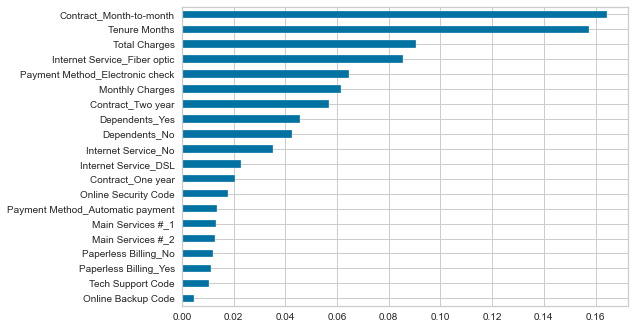

In [27]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

weights.sort_values()[-20:].plot(kind = 'barh')


##### 4.4 LightGBM Model

In [28]:
# build the lightgbm model
import lightgbm as lgb
model = lgb.LGBMClassifier(random_state=0,scale_pos_weight=3)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

# get metrics
print('Precision:', round((precision_score(y_test, y_pred)),4))
print('Recall:', round((recall_score(y_test, y_pred)),4))
print ('ROC AUC Score', round(roc_auc_score(y_test,y_pred),4))
print('Accuracy:' , round((accuracy_score(y_test, y_pred)),4))

# add profit
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (976-100), 0)
    fp = np.where((y_pred==1) & (y==0), -100, 0)
    return (np.sum([tp,fp]))
print ('Profit:', round(calculate_profit(y_test,y_pred)))

Precision: 0.5368
Recall: 0.8117
ROC AUC Score 0.7779
Accuracy: 0.7622
Profit: 241656


In [29]:
# SELECT WEIGHT VALUE IN LIGHTGBM
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = lgb.LGBMClassifier(random_state=0,scale_pos_weight=i)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    y_pred=model.predict(X_test)
    print('ROC AUC with scale pos weight',i,round(metrics.roc_auc_score(y_test, y_pred),4))

ROC AUC with scale pos weight 1 0.7365
ROC AUC with scale pos weight 2 0.7593
ROC AUC with scale pos weight 3 0.7666
ROC AUC with scale pos weight 4 0.7644
ROC AUC with scale pos weight 5 0.7623
ROC AUC with scale pos weight 6 0.7638
ROC AUC with scale pos weight 7 0.7561
ROC AUC with scale pos weight 8 0.7606
ROC AUC with scale pos weight 9 0.7602


<AxesSubplot:>

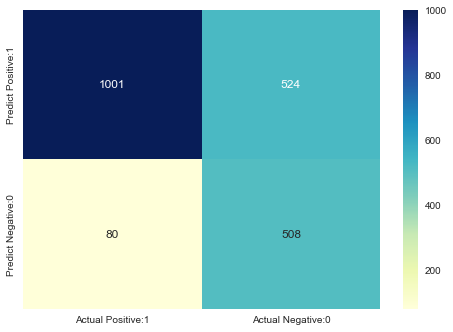

In [30]:
# visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

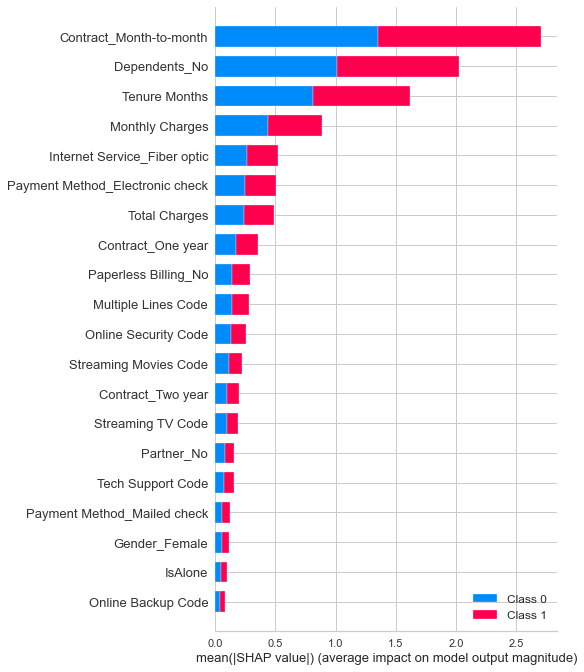

In [31]:
explainerlightgbm = shap.TreeExplainer(model)
shap_values_lightgbm_test = explainerlightgbm.shap_values(X_test)
shap_values_lightgbm_train = explainerlightgbm.shap_values(X_train)
shap_values = explainerlightgbm.shap_values(X_train)

shap.summary_plot(shap_values_lightgbm_train, X_train, plot_type="bar")

##### 4.5 Catboost Model

In [32]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
catboost = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=3)
catboost.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost.predict(X_test)

# metrics
print('Precision:', round((precision_score(y_test, y_pred)),4))
print('Recall:', round((recall_score(y_test, y_pred)),4))
print ('ROC AUC Score', round(roc_auc_score(y_test,y_pred),4))
print('Accuracy:' , round((accuracy_score(y_test, y_pred)),4))

# add profit
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (976-100), 0)
    fp = np.where((y_pred==1) & (y==0), -100, 0)
    return (np.sum([tp,fp]))
print ('Profit:', round(calculate_profit(y_test,y_pred)))


Precision: 0.5366
Recall: 0.835
ROC AUC Score 0.7785
Accuracy: 0.7534
Profit: 387716


In [33]:
# WAY TO SELECT WEIGHT VALUE IN CATBOOST
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    catboost = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=i)
    catboost.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
    y_pred = catboost.predict(X_test)
    print('ROC AUC with scale pos weight',i,round(metrics.roc_auc_score(y_test, y_pred),4))

ROC AUC with scale pos weight 1 0.7365
ROC AUC with scale pos weight 2 0.7699
ROC AUC with scale pos weight 3 0.7785
ROC AUC with scale pos weight 4 0.7764
ROC AUC with scale pos weight 5 0.7717
ROC AUC with scale pos weight 6 0.7583
ROC AUC with scale pos weight 7 0.7488
ROC AUC with scale pos weight 8 0.7399
ROC AUC with scale pos weight 9 0.7403


<AxesSubplot:>

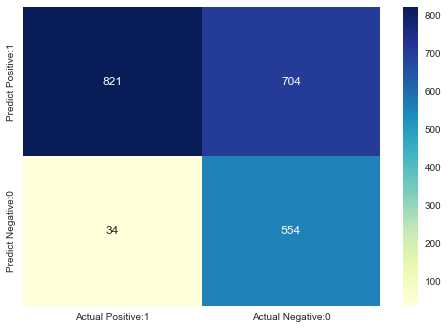

In [34]:
# visualize confusion matrix 
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

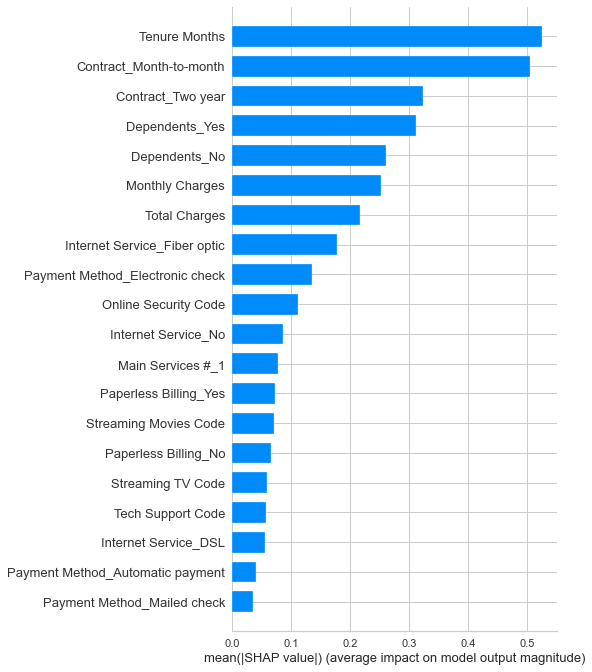

In [35]:
explainercat = shap.TreeExplainer(catboost)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)
shap_values = explainercat.shap_values(X_train)

shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

##### 4.6 XGBoost Model

In [36]:
xgbc = XGBClassifier(random_state=0,scale_pos_weight=3)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)

# metrics
print('Precision:', round((precision_score(y_test, y_pred)),4))
print('Recall:', round((recall_score(y_test, y_pred)),4))
print ('ROC AUC Score', round(roc_auc_score(y_test,y_pred),4))
print('Accuracy:' , round((accuracy_score(y_test, y_pred)),4))

# add profit
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (976-100), 0)
    fp = np.where((y_pred==1) & (y==0), -100, 0)
    return (np.sum([tp,fp]))
print ('Profit:', round(calculate_profit(y_test,y_pred)))


Precision: 0.5691
Recall: 0.7279
ROC AUC Score 0.7577
Accuracy: 0.7709
Profit: 342528


In [37]:
# way to select best weight for the xgbooster
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    xgbc = XGBClassifier(random_state=0,scale_pos_weight=i)
    xgbc.fit(X_train, y_train)
    y_pred = xgbc.predict(X_test)
    print('ROC AUC with scale pos weight',i,round(metrics.roc_auc_score(y_test, y_pred),4))
    

ROC AUC with scale pos weight 1 0.7238
ROC AUC with scale pos weight 2 0.7425
ROC AUC with scale pos weight 3 0.7577
ROC AUC with scale pos weight 4 0.7528
ROC AUC with scale pos weight 5 0.7552
ROC AUC with scale pos weight 6 0.748
ROC AUC with scale pos weight 7 0.7543
ROC AUC with scale pos weight 8 0.7499
ROC AUC with scale pos weight 9 0.7465


 98%|===================| 6882/7043 [00:18<00:00]        

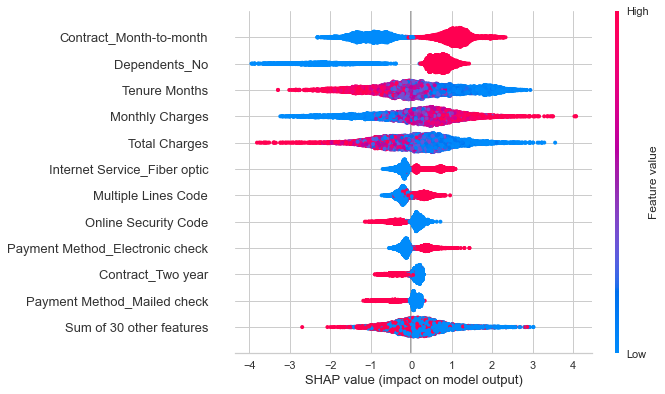

AttributeError: Coefficients are not defined for Booster type None

In [38]:

model = xgbc.fit(X_train, y_train)

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values, max_display=12, order=shap.Explanation.abs.mean(0))

weights = pd.Series(model.coef_[0],
                 index=X.columns.values)

print (weights.sort_values(ascending = True)[:10].plot(kind='bar'))

In [ ]:
# feature selection in case there are more variables than neccesary 

from pmlb import fetch_data
from sklearn.metrics import precision_recall_curve


# Placeholder for model info & metrics    
model_names = []    
training_times = []    
features_set_size = []    
aurocs = []    
auprcs = []

# Generate random variable from uniform distribution
X_train["random"] = np.random.uniform(0, 1, len(X_train))

# Use XGBoost as base estimator for feature selector
selector = XGBClassifier()
selector.fit(X_train, y_train)

# Select features ranked above RV
df = pd.DataFrame({"feature": X_train.columns,"importance": selector.feature_importances_})
rv_importance = df[df["feature"] == "random"]["importance"].iloc[0]
sel_cols = df[df["importance"] > rv_importance]["feature"].tolist()

# For 2 sets of models: one w/ all candidate features and one w/     selected features
for model_name in ["all_features", "selected_features"]:
    if model_name == "all_features":
        feature_set = [i for i in X_train.columns if i != "random"]
    else:
        feature_set = sel_cols
new_X_train = X_train.filter(feature_set)
new_X_test = X_test.filter(feature_set)
num_features = len(feature_set)


# Fit estimator on training set
model = XGBClassifier()
model.fit(new_X_train, y_train)
        
   # Validate on test set
y_scores = model.predict_proba(new_X_test)[:, 1]

   # Append metrics results to placeholder
model_names.append(model_name)
features_set_size.append(num_features)
aurocs.append(roc_auc_score(y_test, y_scores))
p, r, _ = precision_recall_curve(y_test, y_scores)
auprcs.append(auc(r, p))

result = pd.DataFrame({"model_name": model_names, 
                       "features_size": features_set_size, 
                       "auroc": aurocs, 
                       "auprc": auprcs})
print(result)
print('-'*10)
print('features included:',feature_set)